In [14]:
%pylab
%matplotlib inline
import astropy.io.fits as fits
from photutils import daofind

from photutils import CircularAperture,SkyCircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry
import photutils.utils.wcs_helpers

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy.coordinates import SkyCoord
from astropy import wcs
import astropy.units as u

rcParams['image.cmap'] = 'viridis' 

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


Upload the flattened files to Astrometry.net, download "new-image.fits" with sky coordinates added

0.228295859416 0.03396255709084528 6.06516739608


/home/edouglas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10


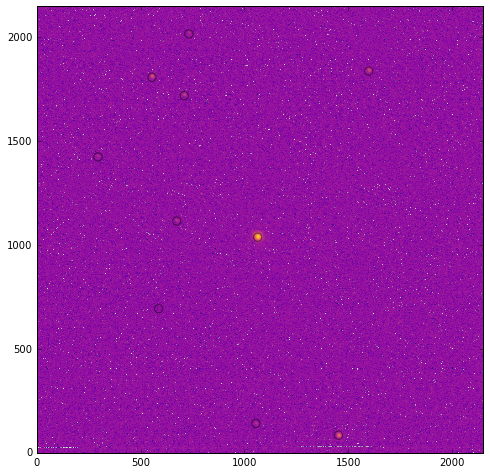

In [15]:
#load example astrometry.net frame:
output_string = "/mnt/camp-storage/ATC2016/transition_disk_accretion_rate/c7560t"
nims = 22
first_frame = 3
basestring = "/mnt/camp-storage/ATC2016/wiyn_09/Converted2016june20/c7560t"
output_file = output_string+'%04i' % first_frame +'flattened.fits'
hdu = fits.open("/mnt/camp-storage/ATC2016/transition_disk_accretion_rate/new-image(1).fits")[0]    
#(this should be replaced with a public dataset)

#find bright sources
image = hdu.data  
bg=np.median(image[:200,:200])
data=image-bg
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)  
print(mean, median, std)    
sources = daofind(data-median, fwhm=10, threshold=7.*std)  #subtracting the 
#so much noise it takes an oversized gaussian to knock it down and not just get hot pixels

#make sure the sources all look like stars:
plt.figure(figsize=[8,8])
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=20)
#these apertures are just for checking we found stars
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(log10(image), cmap='plasma', origin='lower')#, norm=norm)
apertures.plot(color='black', lw=1., alpha=0.5) 


In [47]:
#convert the xy coordinates of the sources to RA and DEC

w = wcs.WCS(hdu.header)

source_skycoods = photutils.utils.wcs_helpers.pixel_to_icrs_coords(sources["xcentroid"], sources["ycentroid"], w)
c = SkyCoord(source_skycoods[0],source_skycoods[1],frame='icrs')

#define the size of the photometry apertures
apertures = SkyCircularAperture(c, r=7. * u.arcsec) 



SingularMatrixError: ERROR 3 in wcsset() at line 2213 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 648 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.


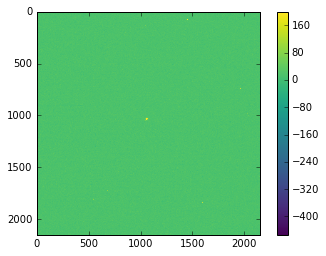

In [52]:
imshow(hdu.data,vmax=200)
colorbar()

In [46]:
#do photometry on each file
import glob
astrometry_files=glob.glob("/home/edouglas/camp-storage/ATC2016/transition_disk_accretion_rate/June20/006*.fits")
phot=np.empty([len(apertures.positions.ra),len(astrometry_files)])
for i,file in enumerate(astrometry_files):
    print(file)
    hdu = fits.open(file)[0]   
    phot_table = aperture_photometry(hdu, apertures)  
    phot[:,i]=np.array(phot_table['aperture_sum'])
    #this is used above to output the file

/home/edouglas/camp-storage/ATC2016/transition_disk_accretion_rate/June20/0060.fits


SingularMatrixError: ERROR 3 in wcsset() at line 2213 of file cextern/wcslib/C/wcs.c:
Linear transformation matrix is singular.
ERROR 3 in linset() at line 648 of file cextern/wcslib/C/lin.c:
PCi_ja matrix is singular.


array([2])

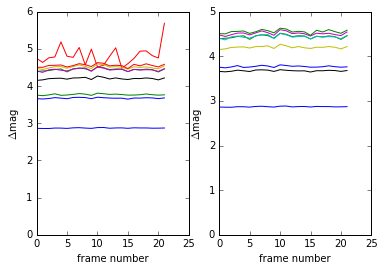

In [40]:
#calculate and plot the difference in magnitudes versus the brightest star
subplot(121)

brightest_row=np.where(phot==phot.max())[0]
delta_mags=(-2.5*np.log10(phot)+2.5*log10(phot[brightest_row])).T
plt.plot(delta_mags)
plt.ylabel("$\Delta$mag")
plt.xlabel("frame number")
subplot(122)
#delete dimmest star
phot_pared=np.delete(phot,where(delta_mags==np.max(delta_mags))[1],axis=0)
delta_mags=(-2.5*np.log10(phot_pared)+2.5*log10(phot_pared[np.where(phot_pared==phot_pared.max())[0]])).T

plt.plot(delta_mags)
plt.ylabel("$\Delta$mag")
plt.xlabel("frame number")


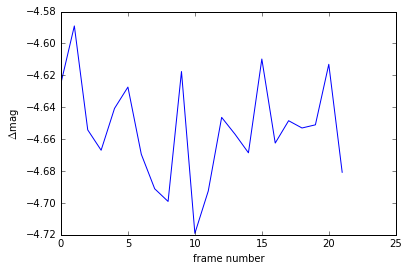

In [43]:
#calculate the delta mag of the target star versus the sum of the others
diff_phot = -2.5*np.log10(np.sum(phot_pared,axis=0)) + (2.5*log10(phot_pared[brightest_row])) 
#this is very simplified, another approach: http://adsabs.harvard.edu/abs/1992PASP..104..435H
plt.plot(diff_phot.T)
plt.ylabel("$\Delta$mag")
plt.xlabel("frame number")

In [37]:
phot_pared

array([  136960.94866514,   133181.7302095 ,   109459.64669785,
         107102.20936978,   135404.27824004,    78868.8221995 ,
          79512.44677926,   109860.29288855,   136976.02632318,
          79941.88157005,    80043.82754678,   108060.79150044,
          79736.35342633,   109319.18310218,   134293.68873866,
         108438.52039957,   107818.82931629,   108483.76551826,
         106410.71032379,    75301.82250436,    79725.71991303,
          33426.39249346,    32093.76378205,    26091.51256703,
          25692.8461093 ,    24770.08635116,    33445.5338608 ,
          18323.76758092,    18197.42372369,    25336.6524634 ,
          33057.27604557,    17760.08505989,    18208.95757419,
          25335.07063061,    18507.73580392,    25553.63095329,
          33012.8030172 ,    25508.76032308,    25613.58781279,
          25254.67156157,    24970.90241703,    18725.02211676,
          18478.7378053 ,    24191.1409999 ,    25958.67439391,
          19022.89275878,    18831.37741